In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchsummary import summary
import pandas as pd
import pickle

In [2]:
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
# Load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 74.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Init layer parameters
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init

import shutil

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            if m.bias is not None:
                init.constant_(m.bias, 0)

In [ ]:
# Resnet
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

[2] Liu, K. 2017. pytorch-cifar: PyTorch implementation of ResNet on CIFAR-10 from scratch. 
    https://github.com/kuangliu/pytorch-cifar. Accessed: 2025-03-14.
'''

# Define Bottleneck Block with Squeeze-and-Excitation (SE)
class BottleneckSE(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, reduction=16):
        super(BottleneckSE, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # Squeeze-and-Excitation (SE) Module
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(planes * self.expansion, planes * self.expansion // reduction)
        self.fc2 = nn.Linear(planes * self.expansion // reduction, planes * self.expansion)
        self.sigmoid = nn.Sigmoid()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        # SE Block
        se = self.global_avg_pool(out)
        se = torch.relu(self.fc1(se.view(se.size(0), -1)))
        se = self.sigmoid(self.fc2(se))
        se = se.view(se.size(0), se.size(1), 1, 1)
        out = out * se  # Attention scaling

        out += self.shortcut(x)
        return torch.relu(out)

# Define Optimized MiniResNet
class OptimizedMiniResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(OptimizedMiniResNet, self).__init__()
        self.in_planes = 32

        # Define layers with BottleneckSE
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256 * BottleneckSE.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def ResNetOpt():
    return OptimizedMiniResNet(BottleneckSE, [2, 4, 5, 2])

In [7]:
# Set up device, model, loss function, optimizer, and learning rate scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNetOpt().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [8]:
# Check the number of parameters
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           1,024
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7          [-1, 128, 32, 32]           4,096
       BatchNorm2d-8          [-1, 128, 32, 32]             256
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
           Linear-10                    [-1, 8]           1,032
           Linear-11                  [-1, 128]           1,152
          Sigmoid-12                  [-1, 128]               0
           Conv2d-13          [-1, 128, 32, 32]           4,096
      BatchNorm2d-14          [-1, 128,

In [9]:
# Initialize parameters
init_params(net)

In [10]:
# Store training and testing accuracy & loss history
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

In [11]:
# Training function
def train(epoch):
    print(f'\nEpoch: {epoch}')
    net.train()
    correct, total = 0, 0
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total
    train_loss /= len(trainloader)
    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.3f}%')
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    return train_acc

In [12]:
# Testing function
def test():
    net.eval()
    correct, total = 0, 0
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100. * correct / total
    test_loss /= len(testloader)
    print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.3f}%')
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    return test_acc

In [13]:
# Train the model
num_epochs = 200
best_models = []
num_best_models = 3
os.makedirs("saved_models", exist_ok=True)  # Ensure the model storage directory exists

for epoch in range(num_epochs):
    train_acc = train(epoch)
    test_acc = test()
    scheduler.step()

    # Save the model if it ranks in the Top-3
    if len(best_models) < num_best_models or test_acc > best_models[-1][0]:
        model_path = f"saved_models/best_model_{epoch}.pth"
        best_models.append((test_acc, model_path))
        best_models.sort(reverse=True, key=lambda x: x[0])  # Sort by accuracy in descending order

         # Keep only the Top-3 models
        if len(best_models) > num_best_models:
            _, removed_model = best_models.pop()
            if os.path.exists(removed_model):
                os.remove(removed_model)

        # Save the current best model
        torch.save(net.state_dict(), model_path)
        print(f"New best model saved: {model_path}, Test Accuracy: {test_acc:.2f}%")

print("Training complete. Top-3 best models:")
for acc, path in best_models:
    print(f"{path} - {acc:.2f}%")


Epoch: 0
Train Loss: 2.014 | Train Accuracy: 27.818%
Test Loss: 1.642 | Test Accuracy: 42.900%
New best model saved: saved_models/best_model_0.pth, Test Accuracy: 42.90%

Epoch: 1
Train Loss: 1.372 | Train Accuracy: 49.722%
Test Loss: 1.263 | Test Accuracy: 54.810%
New best model saved: saved_models/best_model_1.pth, Test Accuracy: 54.81%

Epoch: 2
Train Loss: 1.067 | Train Accuracy: 61.770%
Test Loss: 1.028 | Test Accuracy: 63.880%
New best model saved: saved_models/best_model_2.pth, Test Accuracy: 63.88%

Epoch: 3
Train Loss: 0.875 | Train Accuracy: 69.236%
Test Loss: 0.964 | Test Accuracy: 68.400%
New best model saved: saved_models/best_model_3.pth, Test Accuracy: 68.40%

Epoch: 4
Train Loss: 0.748 | Train Accuracy: 73.908%
Test Loss: 0.813 | Test Accuracy: 72.180%
New best model saved: saved_models/best_model_4.pth, Test Accuracy: 72.18%

Epoch: 5
Train Loss: 0.675 | Train Accuracy: 76.654%
Test Loss: 1.053 | Test Accuracy: 65.110%
New best model saved: saved_models/best_model_5.p

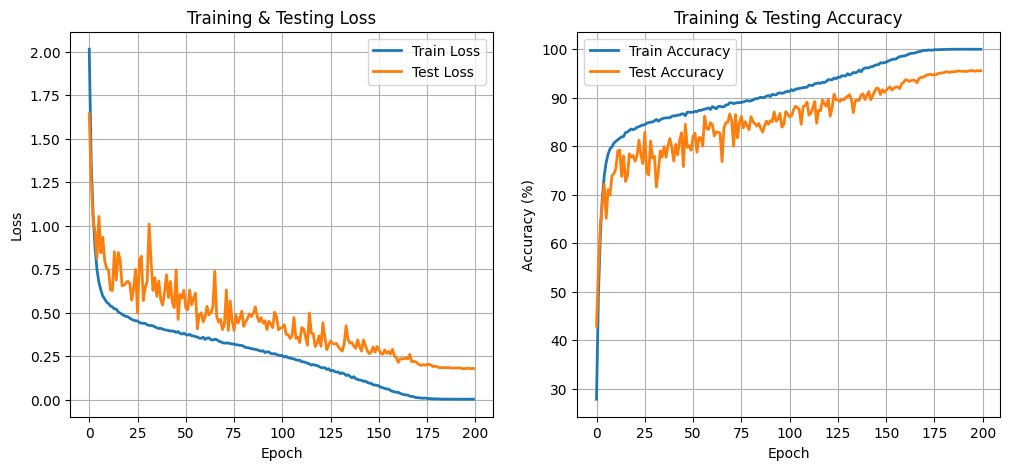

In [14]:
# Plot loss curve and accuracy curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve (left)
axes[0].plot(range(num_epochs), train_loss_history, '-', linewidth=2, label='Train Loss')
axes[0].plot(range(num_epochs), test_loss_history, '-', linewidth=2, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()
axes[0].set_title('Training & Testing Loss')

# Accuracy curve (right)
axes[1].plot(range(num_epochs), train_acc_history, '-', linewidth=2, label='Train Accuracy')
axes[1].plot(range(num_epochs), test_acc_history, '-', linewidth=2, label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True)
axes[1].legend()
axes[1].set_title('Training & Testing Accuracy')

plt.show()

In [15]:
# Load the best model
best_model_path = best_models[0][1]
net.load_state_dict(torch.load(best_model_path, map_location=device))
net.eval()
print(f"Best model loaded: {best_model_path}")

Best model loaded: saved_models/best_model_194.pth


<ipython-input-15-edf2e68e662c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(best_model_path, map_location=device))


In [16]:
# Prediction demonstration (randomly select 5 test images)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images[:5].to(device), labels[:5].to(device)
outputs = net(images)
_, predicted = outputs.max(1)

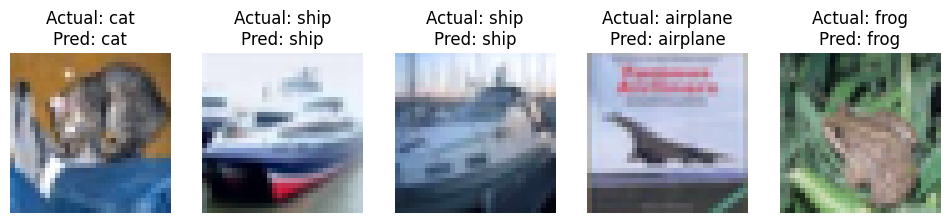

In [17]:
# Visualization
images = images.cpu().numpy()
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img = images[i].transpose((1, 2, 0)) * 0.2023 + 0.4914
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Actual: {classes[labels[i]]}\nPred: {classes[predicted[i]]}')
plt.show()

In [18]:
# Load the .pkl file
file_path = "/content/cifar_test_nolabel.pkl"

with open(file_path, "rb") as f:
    test_new = pickle.load(f)

# Load data
test_images = test_new[b'data']
test_ids = test_new[b'ids']

# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to (C, H, W) format
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize
])

test_tensors = torch.stack([transform(img) for img in test_images])

test_dataset = torch.utils.data.TensorDataset(test_tensors)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Check the shape of the converted data
test_tensors.shape

torch.Size([10000, 3, 32, 32])

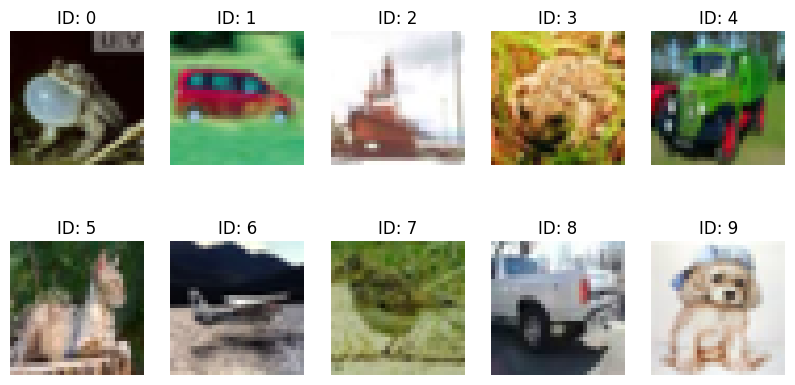

In [19]:
# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    img = test_images[i]
    ax.imshow(img)
    ax.set_title(f"ID: {test_ids[i]}")
    ax.axis("off")

plt.show()

In [20]:
# Prediction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        predictions.extend(predicted.cpu().numpy())

# Save Prediction Results
df = pd.DataFrame({"ID": test_ids, "Labels": predictions})
df.to_csv("predictions.csv", index=False)

print("Prediction completed. Results saved as predictions.csv")

Prediction completed. Results saved as predictions.csv
